In [4]:
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
#import sys
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [175]:
### definição das funções auxiliares ###
def angle(u, v=np.array([1, 0])):
    '''
    Função que calcula o ângulo entre dois vetores
    
    Parameters
    ----------
    u: np.ndarray, dim=(2, )
    v: np.ndarray (default=np.array([1, 0])), dim=(2, )
        vetor horizontal para direita
    
    Returns
    -------
    angle: float
        valor, em radianos, do ângulo entre os vetores
    '''
    u_norm = u/np.linalg.norm(u)
    v_norm = v/np.linalg.norm(v)
    dot    = np.dot(u_norm, v_norm)
    angle  = np.arccos(dot)
    
    return angle

def calculate_I(b, h=None):
    '''
    Função que calcula o momento de inércia
    
    Parameters
    ----------
    b: float
        largura da seção transversal (ou diâmetro)
    h: float (default=None)
        altura da seção transversal, se None considera que trata-se
        de uma seção transversal circular
    '''
    if h is None:
        return np.pi*((b/2)**4)/2
    return (b**3)*h/12

def globalize_K(Ke, total_size, idx):
    '''
    Função que transforma uma matriz Ke (local) em uma matriz K (global)
    
    Parameters
    ----------
    Ke: np.array (dim=len(idx)xlen(idx))
        Matriz de rigidez local
    total_size: int
        tamanho total do sistema (número de variáveis independentes)
    idx: list (or array-like)
        índice das variáveis que Ke se refere a
    '''
    Keg = np.zeros((total_size, total_size))
    Keg[np.ix_(idx, idx)] = Ke
    
    return Keg

def globalize_F(Fe, total_size, idx):
    '''
    Função que transforma uma matriz Fe (local) em uma matriz Fe (global)
    
    Parameters
    ----------
    Fe: np.array (dim=len(idx)x1)
        Matriz de forças distribuidas
    total_size: int
        tamanho total do sistema (número de variáveis independentes)
    idx: list (or array-like)
        índice das variáveis que Fe se refere a
    '''
    Feg = np.zeros(total_size)
    Feg[np.ix_(idx)] = Fe
    
    return Feg

def anula_cond_contorno(A, idx):
    '''
    Anula as linhas e colunas em que se sabe que o movimento/rotação
    é nulo, deixando 1 no lugar
    
    Parameters
    ----------
    A: np.ndarray
        matriz global
    idx: list
        lista dos índices (inteiros, 0-indexados)
    '''
    A_cc = A.copy()
    for var in idx:
        A_cc[var,   :] = 0
        A_cc[:  , var] = 0
        A_cc[var, var] = 1
    return A_cc

def reduz_matriz(A, idx, eliminate=False):
    '''
    Reduz a matriz global com condições de contorno para
    uma matriz apenas com as linhas e colunas dos elementos
    não triviais (não nulos) do sistema
    
    Parameters
    ----------
    A: np.ndarray
        matriz global
    idx: list
        lista dos índices (inteiros, 0-indexados)
    '''
    A_red     = A.copy()
    dimension = A.ndim
    if eliminate == True:
        all_indexes = np.arange(0, A.shape[0])
        difference = set(all_indexes) - set(idx)
        idx = list(difference)
    if dimension > 1:
        A_red = A[np.ix_(idx, idx)]
    else:
        A_red = A[np.ix_(idx)]
    return A_red

def discretiza(ponto1, ponto2, dx, dx_list=[1, 2, 3]):
    """
    Função que discretiza um elemento, dado dois pontos a ele pertencentes.
    Além disso, respeita a imposição de que se não houver como gerar o elemento
    usa um dx menor, e apenas um, da lista de opções.
    """
    #lista de opções
    dx_list = np.array(dx_list)
    dx_menores = dx_list[dx_list <= dx]
    
    #definição de onde é a discretização
    if ponto1[1] == ponto2[1]:
        #tem coordenadas y iguais
        #a discretização é em x
        pto1 = ponto1[0]
        pto2 = ponto2[0]
        orientacao = 'x'
    elif ponto1[0] == ponto2[0]:
        #tem coordenadas x iguais
        #a discretização é em y
        pto1 = ponto1[1]
        pto2 = ponto2[1]
        orientacao = 'y'
    else:
        #tem coordenadas x e y distintas
        print("discretização não horizontal/vertical")
        return 0
    
    #discretizando em dx até o valor que der
    discretizacao = np.arange(pto1, pto2, dx)
    
    #pegando o quanto falta para a discretização
    diff = pto2 - discretizacao[-1]
    
    if diff != 0:
        #se a discretização não foi perfeita
        if diff in dx_menores:
            #se tem um valor dx que encaixe no espaço que 'sobra'
            discretizacao = np.append(discretizacao, discretizacao[-1] + diff)
        else:
            # há um ponto que não encaixa e não temos um dx adequado para ele
            print("Erro na discretização!")
        
    #colocando o vetor com as duas coordenadas
    if orientacao == 'x':
        discretizacao = np.array([np.array([x, ponto1[1]]) for x in discretizacao])
    elif orientacao == 'y':
        discretizacao = np.array([np.array([ponto1[0], y]) for y in discretizacao])
        
    return discretizacao
    

def discretiza_elemento(point_list, dx):
    elemento = []
    for i, ponto in enumerate(point_list[:-1]):
        discretizacao = discretiza(ponto, point_list[i+1], dx)
        if i+2 != len(point_list):
            # se não for o último elemento
            elemento.extend(discretizacao[:-1])
            # não se coloca o último ponto para evitar repetição
        else:
            # se for o último elemento
            elemento.extend(discretizacao)
    return elemento
                
def deleta_phis(deslocamentos,n=3, ):
    """
    Função que acha as deformações em x e em y a partir de um vetor
    resultante do modo de vibrar, ignorando o grau de liberdade phi dos pontos.
    """
    num_gdl = deslocamentos.size
    #deslocamentos[n-1:num_gdl:n] = 0
    desloc = np.delete(deslocamentos, np.arange(n-1, num_gdl, n))
    return desloc
    
def find_index_dispacement(system, point, tipo):
    index = system._find_point_index(point)
    if tipo == 'horizontal':
        return 3*index
    elif tipo == 'vertical':
        return 3*index+1

# Funções de Hermite
H1   = lambda x, L: 1 - 3*x**2/L**2 + 2*x**3/L**3 
dH1  = lambda x, L: -6*x/L**2 + 6*x**2/L**3
d2H1 = lambda x, L: -6/L**2 + 12*x/L**3
H2   = lambda x, L: x - 2*x**2/L + x**3/L**2
dH2  = lambda x, L: 1 - 4*x/L + 3*x**2/L**2
d2H2 = lambda x, L: -4/L + 6*x/L**2
H3   = lambda x, L: 3*x**2/L**2 - 2*x**3/L**3
dH3  = lambda x, L: 6*x/L**2 - 6*x**2/L**3
d2H3 = lambda x, L: 6/L**2 - 12*x/L**3
H4   = lambda x, L: -x**2/L + x**3/L**2
dH4  = lambda x, L: -2*x/L + 3*x**2/L**2
d2H4 = lambda x, L: -2/L + 6*x/L**2

In [182]:
### definição das classes utilizadas ###
class Elemento:
    '''
    Classe para um Elemento, podendo ele ser de viga/pórtico ou de treliça
    '''
    def __init__(self, ini, fim, tipo, params, numero=None):
        '''
        Parameters
        ----------
        ini: np.ndarray
            coordenada do início do elemento
        fim: np.ndarray
            coordenada do fim do elemento
        tipo: str {'viga', 'trelica'}
            tipo de elemento a ser estudado
        params: dict
            dicionário com os seguintes parâmetros (no SI):
            - A: área transversal do elemento
            - E: módulo de Young do elemento
            - rho: densidade do elemento
            - I: momento de inércia do elemento
            outros parâmetros relevantes (como tamanho L e o ângulo de incli-
            nação theta são determinados através de contas com os parâmetros 
            já dados)
        q: float
            valor da carga distribuída no elemento
        numero: int
            número do elemento na estrutura, caso se queira saber de um dado elemento
        '''
        self.ini    = ini
        self.fim    = fim
        self.tipo   = tipo
        self.L      = self.calculate_L()
        self.theta  = self.calculate_theta()
        (self.E  ,
         self.A  ,
         self.rho,
         self.I  ,) = params.values()
        #self.q      = q
        self.Ke     = self.build_Ke_matrix()
        self.Me     = self.build_Me_matrix()
        #inicializa-se como nulo
        self.Fe     = None
        #self.Fe     = self.build_q_array()
        self.Numero = numero
    
    def calculate_L(self, ):
        '''
        Método que calcula o tamanho L do elemento
        '''
        return np.linalg.norm(self.ini - self.fim)
        
    def calculate_theta(self, ):
        '''
        Método que calcula a inclinação do elemento através das
        coordenadas de seu início e seu fim
        '''
        u = self.fim - self.ini
        return angle(u)
    
    def rotate_matrix(self,):
        '''
        Método que cria uma matriz de rotação para o elemento criado
        a partir do ângulo theta
        
        Notes
        -----
        A matriz rotacionada é obtida a partir da seguinte expressao:
        .. math:: [M]_{rot} = [T]^{T}\cdot [M] \cdot [T]
        Com [M] a matriz original (em seu próprio eixo coordenado) e
        [M]_{rot} a matriz rotacionada, sendo [M] uma matriz quadrada
        No caso que querermos rotacionar uma matriz-coluna (carga), 
        deve-se aplicar a seguinte equação:
        .. math:: [C]_{rot} = [T]^{T}\cdot [C]
        '''
        c = np.cos(self.theta)
        s = np.sin(self.theta)
        T = np.array([
            [ c, s, 0,  0, 0, 0], # u1
            [-s, c, 0,  0, 0, 0], # v1
            [ 0, 0, 1,  0, 0, 0], # phi1
            [ 0, 0, 0,  c, s, 0], # u2
            [ 0, 0, 0, -s, c, 0], # v2
            [ 0, 0, 0,  0, 0, 1], # phi2
        ])
        return T
        
    def build_Ke_matrix(self,):
        '''
        Método que constrói a matriz de elasticidade local do elemento
        '''
        E = self.E
        A = self.A
        L = self.L
        I = self.I
        if self.tipo == 'trelica':
            Ke = E*A/L*np.array([
                [ 1, 0, 0, -1, 0, 0], # u1
                [ 0, 0, 0,  0, 0, 0], # v1
                [ 0, 0, 0,  0, 0, 0], # phi1
                [-1, 0, 0,  1, 0, 0], # u2
                [ 0, 0, 0,  0, 0, 0], # v2
                [ 0, 0, 0,  0, 0, 0], # phi2
            ])
            '''
            Ke +=  ((E*I)/L**3)*np.array([
                [0,   0,      0, 0,    0,      0], # u1
                [0,  12,    6*L, 0,  -12,    6*L], # v1
                [0, 6*L, 4*L**2, 0, -6*L, 2*L**2], # phi1
                [0,   0,      0, 0,    0,      0], # u2
                [0, -12,   -6*L, 0,   12,   -6*L], # v2
                [0, 6*L, 2*L**2, 0, -6*L, 4*L**2], # phi2
            ])
            '''
        else:
            Ke = E*A/L*np.array([
                [ 1, 0, 0, -1, 0, 0], # u1
                [ 0, 0, 0,  0, 0, 0], # v1
                [ 0, 0, 0,  0, 0, 0], # phi1
                [-1, 0, 0,  1, 0, 0], # u2
                [ 0, 0, 0,  0, 0, 0], # v2
                [ 0, 0, 0,  0, 0, 0], # phi2
            ])
            Ke +=  ((E*I)/L**3)*np.array([
                [0,   0,      0, 0,    0,      0], # u1
                [0,  12,    6*L, 0,  -12,    6*L], # v1
                [0, 6*L, 4*L**2, 0, -6*L, 2*L**2], # phi1
                [0,   0,      0, 0,    0,      0], # u2
                [0, -12,   -6*L, 0,   12,   -6*L], # v2
                [0, 6*L, 2*L**2, 0, -6*L, 4*L**2], # phi2
            ])
        T   = self.rotate_matrix()
        Ke_ = T.T @ Ke @ T
            
        return Ke_
    
    def build_Me_matrix(self,):
        '''
        Método que constrói a matriz de massas local do elemento
        '''
        E = self.E
        A = self.A
        L = self.L
        I = self.I
        rho = self.rho
        if self.tipo == 'trelica':
            Me = rho*A*L/6*np.array([
                [2, 0, 0, 1, 0, 0], # u1
                [0, 0, 0, 0, 0, 0], # v1
                [0, 0, 0, 0, 0, 0], # phi1
                [1, 0, 0, 2, 0, 0], # u2
                [0, 0, 0, 0, 0, 0],  # v2
                [0, 0, 0, 0, 0, 0], # phi2
            ])
            '''
            Me += rho*A*L/420*np.array([
                [0,    0,       0, 0,     0,       0], # u1
                [0,  156,    22*L, 0,    54,   -13*L], # v1
                [0, 22*L,  4*L**2, 0,  13*L, -3*L**2], # phi1
                [0,    0,       0, 0,     0,       0], # u2
                [0,   54,    13*L, 0,   156,   -22*L], # v2
                [0,-13*L, -3*L**2, 0, -22*L,  4*L**2], # phi2
            ])
            '''
        else:
            Me = (rho*A*L/6*np.array([
                [2, 0, 0, 1, 0, 0], # u1
                [0, 0, 0, 0, 0, 0], # v1
                [0, 0, 0, 0, 0, 0], # phi1
                [1, 0, 0, 2, 0, 0], # u2
                [0, 0, 0, 0, 0, 0],  # v2
                [0, 0, 0, 0, 0, 0], # phi2
            ])
            
            +   rho*A*L/420*np.array([
                [0,    0,       0, 0,     0,       0], # u1
                [0,  156,    22*L, 0,    54,   -13*L], # v1
                [0, 22*L,  4*L**2, 0,  13*L, -3*L**2], # phi1
                [0,    0,       0, 0,     0,       0], # u2
                [0,   54,    13*L, 0,   156,   -22*L], # v2
                [0,-13*L, -3*L**2, 0, -22*L,  4*L**2], # phi2
            ])
            )
        T   = self.rotate_matrix()
        Me_ = T.T @ Me @ T
        
        return Me_
    
    def build_q_array(self,q):
        '''
        Método que constrói a matriz-coluna de forças distribuídas
        local do elemento, para uma função q que depende do tempo
        '''
        L  = self.L
                           
        Fe = q*L/12*np.array(
            [0,  #u1
             6,  #v1
             L,  #phi1 
             0,  #u2 
             6,  #v2 
             -L  #phi2
        ])
        
        T   = self.rotate_matrix()
        Fe_ = T.T @ Fe
        self.Fe = Fe_
        pass
    
    def is_contained(self, inicio_dominio, final_dominio):
        """
        Método que determina se um elemento é pertence ao domínio determinado
        por dois nós.
        """
        contained_ini = np.all(self.ini >= inicio_dominio)
        contained_fim = np.all(self.fim <= final_dominio)
        return contained_ini and contained_fim
    
class Sistema:
    """
    Classe que abstrai a criação de um sistema a ser resolvido
    """
    def __init__(
            self,
            struct_dict,
            dict_cc,
            dict_cargas_distribuidas,
            list_cargas_pontuais,
            alpha        = 0.1217,
            beta         = 0.0087,
            gamma        = 1/2,
            beta_newmark = 1/4,
            dx=1
        ):
        self.struct_dict     = struct_dict
        self.cc              = dict_cc
        self.cargas          = dict_cargas_distribuidas
        self.forcas          = list_cargas_pontuais
        self.dx              = dx
        (self.point_list, 
        self.elements,)       = self._gera_elementos()
        self.struct_ids      = self._gera_ids()
        self.num_nodes       = len(self.point_list)
        self.num_elements    = len(self.elements)
        self.num_gdl         = 3*len(self.point_list)
        #para cada nó, temos u, v e phi
        
        #parametros Rayleigh
        self.alpha = alpha
        self.beta  = beta
        
        #cria-se as matrizes vazias
        self.Keg = self._create_global_matrix()
        self.Meg = self._create_global_matrix()
        self.Feg = self._create_global_vector()
        self.Ceg = self._create_global_vector()
        
        #a partir dai, se preenche as matrizes
        self._fill_global_rigidity_matrix() #matriz de rigidez
        self._fill_global_mass_matrix()     #matriz de massa
        if self.dx == 1:
            #só usados em análises com dx=1
            self.Feg = self._fill_Fe_matrix()   #vetor de cargas inicial
            self.Ceg = self._fill_Ce_matrix()   #vetor de forças incial
        

        
        #aplica-se as condições de contorno na matrizx de rigidez
        self._apply_cc()
        

    def _gera_elementos(self,):
        #pontos (x, y)/ nós do sistema
        point_list = []
        
        #elementos do sistema, que ligam dois nós distintos
        elements = []
        
        #propriedades que são passadas aos elementos
        keys_elemento = ['E', 'A', 'rho', 'I']
        
        #para cada uma das estruturas
        num_element=0
        for struct in self.struct_dict:
            #pegamos os pontos que as compõe
            points = self.struct_dict[struct]['points']
            #adicionamos estes nós a lista de todos os nós
            point_list += points
            
            #com eles, pode-se criar cada elemento dessa estrutura
            for i in range(len(points)-1):
                #criação dos elementos
                element = Elemento(
                    points[i], points[i+1], 
                    self.struct_dict[struct]['tipo'], 
                    {key: self.struct_dict[struct][key] for key in keys_elemento},
                    numero=num_element
                )
                elements.append(element)
                num_element += 1

        #pega os nós unicos apenas
        point_list = np.unique(point_list, axis=0)
        
        return point_list, elements
    
    def _gera_ids(self,):
        #criar uma lista dos ids na lista de pontos que correspondem aos
        # elementos da estrutura, assim pode-se plotar a deformação deles
        struct_ids = {}
        #dicionario com os elementos e os ids dos pontos
        for struct in self.struct_dict:
            #para cada estrutura se pega os pontos dela
            points = self.struct_dict[struct]['points']
            points_ids_element = []
            for point in points:
                #para cada ponto se encontra os ids correspondentes
                id_ponto = self._find_point_index(point)
                points_ids_element.append(id_ponto)
            #adiciona-se os ids do elemento
            struct_ids[struct] = points_ids_element
        return struct_ids
    
    def _create_global_matrix(self,):
        Keg = np.zeros((self.num_gdl, self.num_gdl))
        return Keg
    
    def _create_global_vector(self,):
        Feg = np.zeros((self.num_gdl, 1))
        return Feg

    def _find_point_index(self, point):
        points   = self.point_list
        mask = np.all(points == point,axis=1)
        
        index = int(np.where(mask)[0])
        return index
        
    def _find_element_indexes(self, element):
        '''
        Função que dado um elemento da estrutura, encontra o índice dos nós
        que este elemento liga
        '''
        ini, fim = element.ini, element.fim
        
        ini = self._find_point_index(ini)
        fim = self._find_point_index(fim)
        
        return ini, fim
    
    def _find_element_by_indexes(self,ini, fim):
        #acha um elemento dentre todos por seus indíces
        for el in self.elements:
            el_id_ini, el_id_fim = self._find_element_indexes(el)
            if el_id_ini == ini and el_id_fim == fim:
                return el
        #se não achar nenhum elemento
        return None
    
    def _find_element_by_number(self, number):
        #acha um elemento dentre todos por seu número
        for el in self.elements:
            num = el.Numero
            if number == num:
                return el
        #se não achar nenhum elemento
        return None
    
    def _fill_global_rigidity_matrix(self,):
        #para cada elemento, se adiciona as suas componentes à matriz global
        for i, el in enumerate(self.elements):
            ini_index, fim_index = self._find_element_indexes(el)
            #pega-se os nós do elemento
            
            Ke_local = el.Ke
            #pega-se sua matriz de rigidez local
            
            indexes_ini = np.arange(3*ini_index, 3*(ini_index+1))
            indexes_fim = np.arange(3*fim_index, 3*(fim_index+1))
            indexes = np.concatenate((indexes_ini, indexes_fim), axis=0)
            #com os indices, pode-se saber em quais posições colocar na 
            # matriz global
            
            Ke_globalizado = globalize_K(Ke_local, self.num_gdl, indexes)
            self.Keg += Ke_globalizado
        pass
            
    def _fill_global_mass_matrix(self,):
        #para cada elemento, se adiciona para a matriz de massa global
        for el in self.elements:
            ini_index, fim_index = self._find_element_indexes(el)
            #pega-se os nós do elemento
            
            Me_local = el.Me
            #pega-se sua matriz de rigidez local
            
            indexes_ini = np.arange(3*ini_index, 3*(ini_index+1))
            indexes_fim = np.arange(3*fim_index, 3*(fim_index+1))
            indexes = np.concatenate((indexes_ini, indexes_fim), axis=0)
            #com os indices, pode-se saber em quais posições colocar na 
            # matriz global
            
            #se globaliza a matriz Me
            Me_globalizado = globalize_K(Me_local, self.num_gdl, indexes)
            self.Meg += Me_globalizado
        pass
       
    def _fill_Fe_matrix(self,t=0):
        #cria-se a matriz de cargas distribuidas vazia
        Feg = np.zeros(self.num_gdl)
        
        for grupo in self.cargas:
            #q_func depende de t e da posição
            inicio, final, q_func  = self.cargas[grupo]
            for elemento in self.elements:
                tem_carga = elemento.is_contained(inicio, final)
                if tem_carga:
                    elemento.build_q_array(q_func(t))
                    Fe_local = elemento.Fe
                    ponto_inicial = elemento.ini
                    ponto_final   = elemento.fim
                    
                    ind           = self._find_point_index(ponto_inicial) 
                    idx           = [3*ind, 3*ind+1, 3*ind+2]
                    ind           = self._find_point_index(ponto_final)
                    idx          += [3*ind, 3*ind+1, 3*ind+2]
                    
                    Fe_globalizada = globalize_F(Fe_local, self.num_gdl, idx)
                    Feg += Fe_globalizada
        return Feg
    
    def _fill_Ce_matrix(self,t=0):
        #cria-se a matriz de forças vazia
        Ceg = np.zeros(self.num_gdl)

        for forca in self.forcas:
            #F_func depende do tempo e da posição
            pontos_aplicacao, F_func, graus_atuantes = forca
            
            for ponto in pontos_aplicacao:
                modulo_F = F_func(t, ponto[0])
                
                indice = self._find_point_index(ponto)
                indices = []
            
                forcas = []
                if 'u' in graus_atuantes:
                    forcas.append(modulo_F)
                else:
                    forcas.append(0)
                if 'v' in graus_atuantes:
                    forcas.append(modulo_F)
                else:
                    forcas.append(0)
                if 'phi' in graus_atuantes:
                    forcas.append(modulo_F)
                else:
                    forcas.append(0)

                #indices
                indices.append(3*indice)
                indices.append(3*indice+1)
                indices.append(3*indice+2)
                
                Ce_local       = np.array(forcas)
                Ce_globalizada = globalize_F(
                                    Ce_local,
                                    self.num_gdl,
                                    indices
                )

                Ceg += Ce_globalizada   
        return Ceg
    
    def _apply_cc(self,):
        #precisa-se de uma forma de pegar os pontos com condição de contorno
        # e quais movimentos estão restritos.
        indices_restritos_global = []
        for tipo_cc in self.cc.keys():
            #cada tipo de condição tem pontos de aplicação e os movimentos que restringe
            lista_aplicacoes = self.cc[tipo_cc]
            for tupla in lista_aplicacoes:
                ponto_aplicacao, restricoes = tupla
                indice = self._find_point_index(ponto_aplicacao)
                
                
                if 'u' in restricoes:
                    indices_restritos_global.append(3*indice)
                if 'v' in restricoes:
                    indices_restritos_global.append(3*indice+1)
                if 'phi' in restricoes:
                    indices_restritos_global.append(3*indice+2)
        self.Meg = anula_cond_contorno(self.Meg, indices_restritos_global)
        self.Keg = anula_cond_contorno(self.Keg, indices_restritos_global)
        pass
    
    def reduz_graus_redundantes(self,):
        indices_restritos_global = []
        for tipo_cc in self.cc.keys():
            lista_aplicacoes = self.cc[tipo_cc]
            for tupla in lista_aplicacoes:
                ponto_aplicacao, restricoes = tupla
                indice = self._find_point_index(ponto_aplicacao)
                
                if 'u' in restricoes:
                    indices_restritos_global.append(3*indice)
                if 'v' in restricoes:
                    indices_restritos_global.append(3*indice+1)
                if 'phi' in restricoes:
                    indices_restritos_global.append(3*indice+2)
        Meg = reduz_matriz(self.Meg, indices_restritos_global, eliminate=True)
        Keg = reduz_matriz(self.Keg, indices_restritos_global, eliminate=True)
        if self.dx == 1:
            Ceg = reduz_matriz(self.Ceg, indices_restritos_global, eliminate=True)
            Feg = reduz_matriz(self.Feg, indices_restritos_global, eliminate=True)
        else:
            Ceg, Feg = self.Ceg, self.Feg
        return Meg, Keg, Ceg, Feg, indices_restritos_global

    def solve_system(self,):
        """
        Função que resolve o sistema sendo ddot{U} nula. 
        Com isto, pode-se encontrar a condição inicial do sistema para
        uma análise transiente, caso o sistema inicie com forças/cargas.
        """
        lado_direito  = self.Ceg + self.Feg
        lado_esquerdo = self.Keg
        Ue = np.linalg.solve(lado_esquerdo, lado_direito)
        return Ue
    
    def acha_modos_de_vibrar(self,n=6):
        Meg, Keg, Ceg, Feg, restritos = self.reduz_graus_redundantes()
        A = np.linalg.inv(Meg) @ Keg
        values, vectors = np.linalg.eig(A)
        values = np.sqrt(values)/(2*np.pi)
                
        idx = values.argsort()#[::-1]   
        values = values[idx]
        vectors = vectors[:,idx].T
        
        #para voltar ao sistema orginal, vamos pegar os indices livres
        graus_totais = np.arange(self.num_gdl)
        #os restritos já temos da função que restringe
        livres = np.array(list(set(graus_totais) - set(restritos)))
        deformacoes = []
        for i in range(n):
            #cria-se uma matriz de deslocamentos vazia
            u = np.zeros(self.Keg.shape[0])
            u[np.ix_(livres)] = vectors[i]
            deformacao = deleta_phis(u)
            deformacao = np.array(deformacao)
            
            deformacao = deformacao.reshape((-1,2))
            deformacoes.append(deformacao)
        #valores de frequencia natural
        #deformacoes em x e y para cada nó do sistema
        return values[:n], deformacoes
    
    def plot_struct(self, 
                    escala=1,
                    deformacoes=None,
                    node_names=False, 
                    elements_names=False,
                    fontsize=4,
                   legend=None):
        plt.figure(figsize=(8, 6), dpi=400)
        lines, names = [], []
        for struct in self.struct_dict:
            color = self.struct_dict[struct]['color']
            lines.append(Line2D([0], [0], color=color, lw=2))
            names.append(struct)
            ids = self.struct_ids[struct]
            points = self.point_list[np.ix_(ids)]
            x, y = zip(*points)
            if deformacoes is None:
                #não passamos deformacoes
                x_def = np.zeros_like(x)
                y_def = np.zeros_like(y)
            else:
                points_deformados = deformacoes[np.ix_(ids)]
                x_def, y_def = zip(*points_deformados) 
            x_new = [original+escala*deformacao for original, deformacao in zip(x, x_def)]
            y_new = [original+escala*deformacao for original, deformacao in zip(y, y_def)]
            #plota-se os nós
            plt.scatter(x_new, y_new, facecolors='none', s=3, edgecolors=color)
            if node_names == True:
                from adjustText import adjust_text
                ax = plt.gca()
                texts = [plt.text(x_new[i], y_new[i], '%s' %ide, fontsize=fontsize)
                         for i, ide in enumerate(ids)]
                adjust_text(texts)
            
            #coloca-se a linha ligando os pontos
            texts_elements = []
            for i in range(0, len(x)-1):
                plt.plot(x_new[i:i+2], y_new[i:i+2], color+'-')
                if elements_names == True:
                    #acha-se o elemento
                    elemento = self._find_element_by_indexes(ids[i], ids[i+1])
                    num = elemento.Numero
                    text =  plt.text((x_new[i]+x_new[i+1])/2, 
                                      (y_new[i]+y_new[i+1])/2, 
                                     '%s' %num,
                                     fontsize=fontsize)
                    texts_elements.append(text)      
        ax = plt.gca()
        ax.legend(lines, names)
        if legend != None:
            plt.title(legend)
        pass
    
    def _gera_omegas(self, wi=0, wf=10, dw=0.01, fator=10):
        omegas, _ = self.acha_modos_de_vibrar()
        omegas = [omega for omega in omegas if omega<wf]
        omegas = [wi-dw] + omegas
        omegas = omegas + [wf-dw]
        omega_atual = omegas[0]
        omega_prox  = omegas[1]
        omega_vector = np.array([])
        for i in range(1, len(omegas)):
            antes = np.arange(omega_atual+dw, omega_prox-dw, dw)
            proximo = np.arange(omega_prox-dw, omega_prox+dw, dw/fator)
            omega = np.concatenate((antes, proximo))
            #depois = np.arange(omega_prox+dw, wf, dw)
            omega_atual = omegas[i]
            if i != len(omegas)-1:
                omega_prox  = omegas[i+1]
            omega_vector = np.concatenate((omega_vector, omega))
        return omega_vector
    
    def analise_harmonica(self,):
        omega_vector = self._gera_omegas()
        
        freq_vector = (2*np.pi)*omega_vector
        
        F = self._f(0)
        
        U_total = np.zeros((self.num_gdl, len(omega_vector)))
        for i, omega in enumerate(freq_vector):
            K_chapeu = (-omega**2 * self.Meg + self.Keg)
            try:
                U = np.linalg.solve(K_chapeu, F)
            except:
                pass
            U_total[:, i] = U
        return np.abs(U_total), omega_vector
            
    def _C(self, t):
        return self._fill_Ce_matrix(t)
    
    def _F(self, t):
        return self._fill_Fe_matrix(t)
    
    def _f(self,t):
        f = self._C(t) + self._F(t)
        return f
        
    def sistema_transiente(self, gamma, beta_newmark, tf, dt, cc_nula=False):
        Meg, Keg, Ceg, Feg, restritos = self.reduz_graus_redundantes()
        #para voltar ao sistema orginal, vamos pegar os indices livres
        graus_totais = np.arange(self.num_gdl)
        #os restritos já temos da função que restringe
        livres = np.array(list(set(graus_totais) - set(restritos)))
        
        #matriz de amortecimento
        Cgm = self.alpha * Meg + self.beta * Keg

        #cria-se o vetor de tempos
        time_vector = np.arange(0, tf, dt)
        
        #coloca-se as condições iniciais
        if not cc_nula:
            U_atual = self.solve_system()[np.ix_(livres)]
        else:
            U_atual = np.zeros_like(livres)
        V_atual = np.zeros_like(livres)
        A_atual = np.linalg.inv(Meg) @ (
            self._f(0)[np.ix_(livres)] - Cgm@V_atual - Keg@U_atual
        )
        
        M_chapeu = Meg + dt*gamma*Cgm+(dt**2)*beta_newmark*Keg
        
        U_transiente = np.zeros((self.num_gdl, len(time_vector)))
        
        for i, t in enumerate(time_vector):
            #U_atual, V_atual, A_atual
            U_transiente[:, i][np.ix_(livres)] = U_atual
            
            F_fut = self._f(t+dt)[np.ix_(livres)]
            F_chapeu = (F_fut 
                - Cgm@(V_atual + dt*(1-gamma)*A_atual)
                - Keg@(U_atual + dt*V_atual+((dt**2)/2)*(1-2*beta_newmark)*A_atual)
            )
            
            A_fut = np.linalg.solve(M_chapeu, F_chapeu)
            U_fut = (U_atual 
                + dt*V_atual 
                + ((dt**2)/2)*((1-2*beta_newmark)*A_atual + 2*beta_newmark*A_fut)
            )
            V_fut = (V_atual
                + dt* ((1-gamma)*A_atual + gamma*A_fut)
            )
            
            #atualiza-se os vetores
            U_atual = U_fut
            V_atual = V_fut
            A_atual = A_fut
                        
        return U_transiente, time_vector

In [213]:
### definição da geometria ###

# Pontos notáveis ([x, y])
A = np.array([ 0,  0])
B = np.array([ 5,  0])
C = np.array([ 9,  0])
D = np.array([18,  0])
E = np.array([36,  0])
F = np.array([36, 18])
G = np.array([36, -5]) # ponto criado artificialmente
H = np.array([45,  0]) # ponto criado artificialmente
I = np.array([65,  0]) # ponto criado artificialmente

# Dimensões vigas/treliças
A1 = ( 1.8, 0.9) # torre
A2 = ( 0.9, 0.9) # ponte
D3 = (0.05,)     # treliças

# Propriedades
Young_modulus = 210e9 #Pa
rho           = 7600  #Kg/m^3

#valores de dx e valor escolhido
dx_list = [1, 2, 3]
dx = 1

# Plataforma (viga)
# A-B-C-D-E-H-I
plataforma_points = [A, B, C, D, E, H, I]
plataforma_points = discretiza_elemento(plataforma_points, dx)

# Torre (viga)
# G-E-F
torre_points = [G, E, F]
torre_points = discretiza_elemento(torre_points, dx)

# Cabos (treliça)
# 1: B-F
cabo1_points = [B, F]
# 2: D-F
cabo2_points = [D, F]
# 3: I-F
cabo3_points = [I, F]

## parâmetros da análise transiente ##

#valores de va e valor escolhido
va_list = [0.5, 1, 2]
va= 0.5

#discretização no tempo
deltat = 0.1

# Valores iniciais de N1 e N2, número de pessoas, em função do tempo
def n1(t, va=1):
    if t < 27/va:
        return 20
    elif 27/va <= t and t <= 47/va:
        return va*t-7
    else:# t > 47/va
        return 40

def n2(t, va=1):
    if t<= 20/va:
        return 20 - va*t
    else: #t > 20/va
        return 0

N1 = lambda t: n1(t, va=va)
N2 = lambda t: n2(t, va=va)

# Lambda functions para o valor da carga distribuida
# L é parâmetro desta fórmula para o caso em que queremos dividir os elementos com
# carga concentrada em sub-elementos, os quais terão suas próprias cargas distribuidas
q  = lambda t, N, L: -N(t)*80*9.8/L
#importante ressaltar o sinal negativo (-) já que a força aponta para baixo!
q1 = lambda t: q(t, N1, 9)
q2 = lambda t: q(t, N2, 9)



#função para definir a força cortante
def v_i(t, x_ponto, va=1):
    if t <= (E[0] - x_ponto)/va:
        return 0
    elif t > (E[0] - x_ponto)/va and t <= (E[0] + 20 - x_ponto)/va:
        return -80*9.8*(1 - np.cos(2*np.pi*va*t))/2
    else:
        return 0
Vi = lambda t, x: v_i(t, x, va=va)
    
## montagem do sistema ##

sistema_dict = {
    'Plataforma' : {
        'points': plataforma_points,
        'A': A2[0]*A2[1],
        'tipo': 'viga/portico',
        'E': Young_modulus,
        'color': 'b',
        'I': calculate_I(A2[0], A2[1]),
        'rho': rho,
    },
    'Torre': {
        'points': torre_points,
        'A': A1[0]*A1[1],
        'tipo': 'viga/portico',
        'E': Young_modulus,
        'color': 'r',
        'I': calculate_I(A1[0], A1[1]),
        'rho': rho,
    },
    'Cabo1': {
        'points': cabo1_points,
        'A': (np.pi*D3[0]**2)/4,
        'tipo': 'trelica',
        'E': Young_modulus,
        'color': 'g',
        'I': calculate_I(D3[0]),
        'rho': rho,
    },
    'Cabo2': {
        'points': cabo2_points,
        'A': (np.pi*D3[0]**2)/4,
        'tipo': 'trelica',
        'E': Young_modulus,
        'color': 'g',
        'I': calculate_I(D3[0]),
        'rho': rho,
    },
    'Cabo3': {
        'points': cabo3_points,
        'A': (np.pi*D3[0]**2)/4,
        'tipo': 'trelica',
        'E': Young_modulus,
        'color': 'g',
        'I': calculate_I(D3[0]),
        'rho': rho,
    },
}

condicoes_contorno_dict = {
    #tipo_cc: [ponto_aplicação, [graus_restringidos]],
    'engaste':       [(G, ['u', 'v', 'phi'])],
    'apoio fixo': [(I, ['u', 'v'])],
}

#N1 e N2 são duas funções do tempo
dict_cargas_distribuidas = {
    #carga : [inicio, fim, q(t, posicao)],
    "grupo1": [A, C, q1],
    "grupo2": [E, H, q2],
}

lista_forcas = [
    #[[pontos_aplicação], módulo_F(t, posicao), [graus_atuantes]],
    [discretiza_elemento([C, E], 1), Vi, ['v']]
]


sistema = Sistema(
    sistema_dict,
    condicoes_contorno_dict,
    dict_cargas_distribuidas,
    lista_forcas,
    dx=dx
)

#a.i
values, vectors = sistema.acha_modos_de_vibrar()

#a.ii
U_transiente, time_vector = sistema.sistema_transiente(
                #gamma e betas do método da aceleração média constante
                gamma= 1/2, 
                beta = 1/4,
                #tempo final de 55/va
                tf = 55/va,
                #delta t para simulação
                deltat = deltat
)


#define-se novas funções
def v_i_transiente(t=0, x=0):
    return -80*9.8
Vi_harmonica = lambda t, x: v_i_transiente(t)

lista_forcas_harmonica = [
    #[[pontos_aplicação], módulo_F(t, posicao), [graus_atuantes]],
    [discretiza_elemento([C, E], 1), Vi_harmonica, ['v']]
]

sistema_hamonico = Sistema(
   sistema_dict,
   condicoes_contorno_dict,
   dict_cargas_distribuidas,
   lista_forcas_harmonica
)

#a.iii
U_harmonico, omegas = sistema_hamonico.analise_harmonica()


# pontos solicitados no enunciado
indice_A = find_index_dispacement(sistema, A, 'vertical')
indice_B = find_index_dispacement(sistema, B, 'vertical')
indice_C = find_index_dispacement(sistema, C, 'vertical')
indice_F = find_index_dispacement(sistema, F, 'horizontal')

TypeError: sistema_transiente() got an unexpected keyword argument 'beta'

In [197]:
va = 1
U_transiente01, time_vector01 = sistema.sistema_transiente(1/2, 1/4, 55/va, 0.1, cc_nula=False)
U_transiente001, time_vector001 = sistema.sistema_transiente(1/2, 1/4, 55/va, 0.01, cc_nula=False)
U_transiente0005, time_vector0005 = sistema.sistema_transiente(1/2, 1/4, 55/va, 0.005, cc_nula=False)

Text(0.5, 1.0, 'Deslocamento vertical do ponto notável $\\mathbf{A}$ com $v_{a} = $1 m/s')

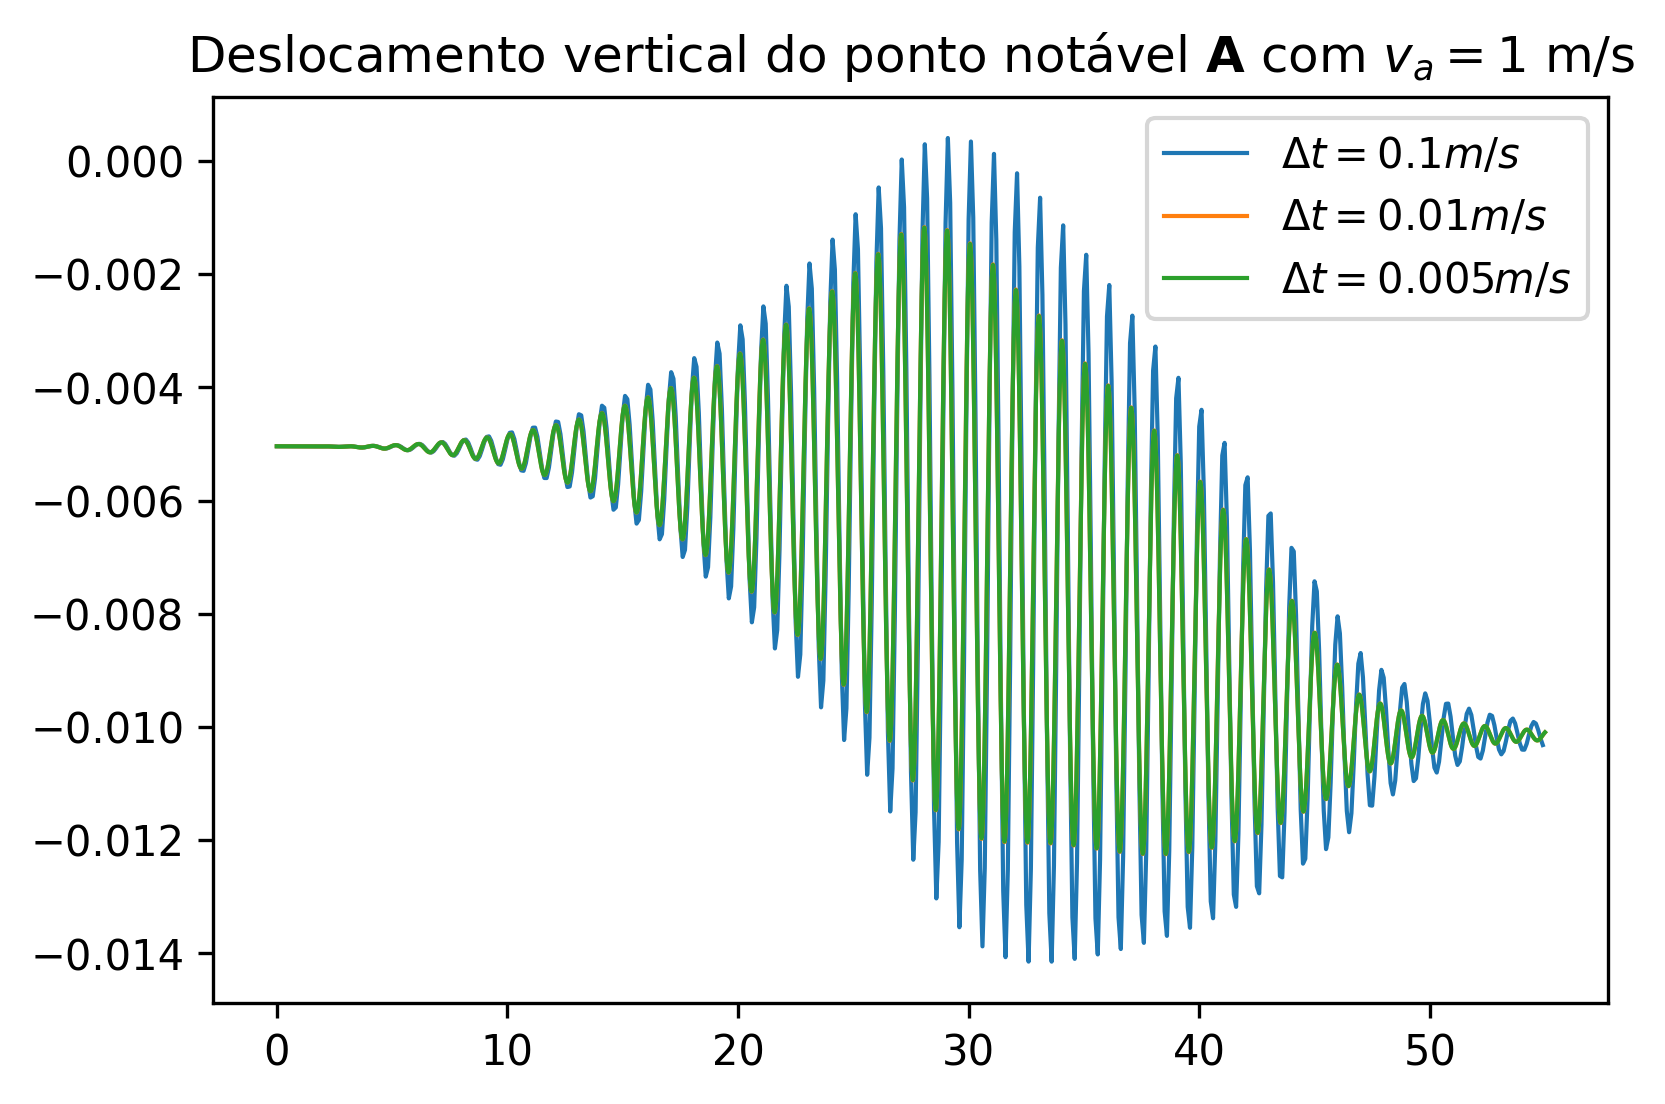

In [211]:

#A ,B e C e o deslocamento horizontal do ponto F.
legenda = r"Deslocamento vertical do ponto notável $\mathbf{A}$ com $v_{a} = $" + f'{va} m/s' 
plt.figure(dpi=300)

plt.plot(time_vector01, U_transiente01[indice_A], label=r'$\Delta t = 0.1 m/s$',   linewidth=1)
plt.plot(time_vector001, U_transiente001[indice_A], label=r'$\Delta t = 0.01 m/s$',   linewidth=1)
plt.plot(time_vector0005, U_transiente0005[indice_A], label=r'$\Delta t = 0.005 m/s$',   linewidth=1)

plt.legend()
ax=plt.gca()

plt.title(legenda)


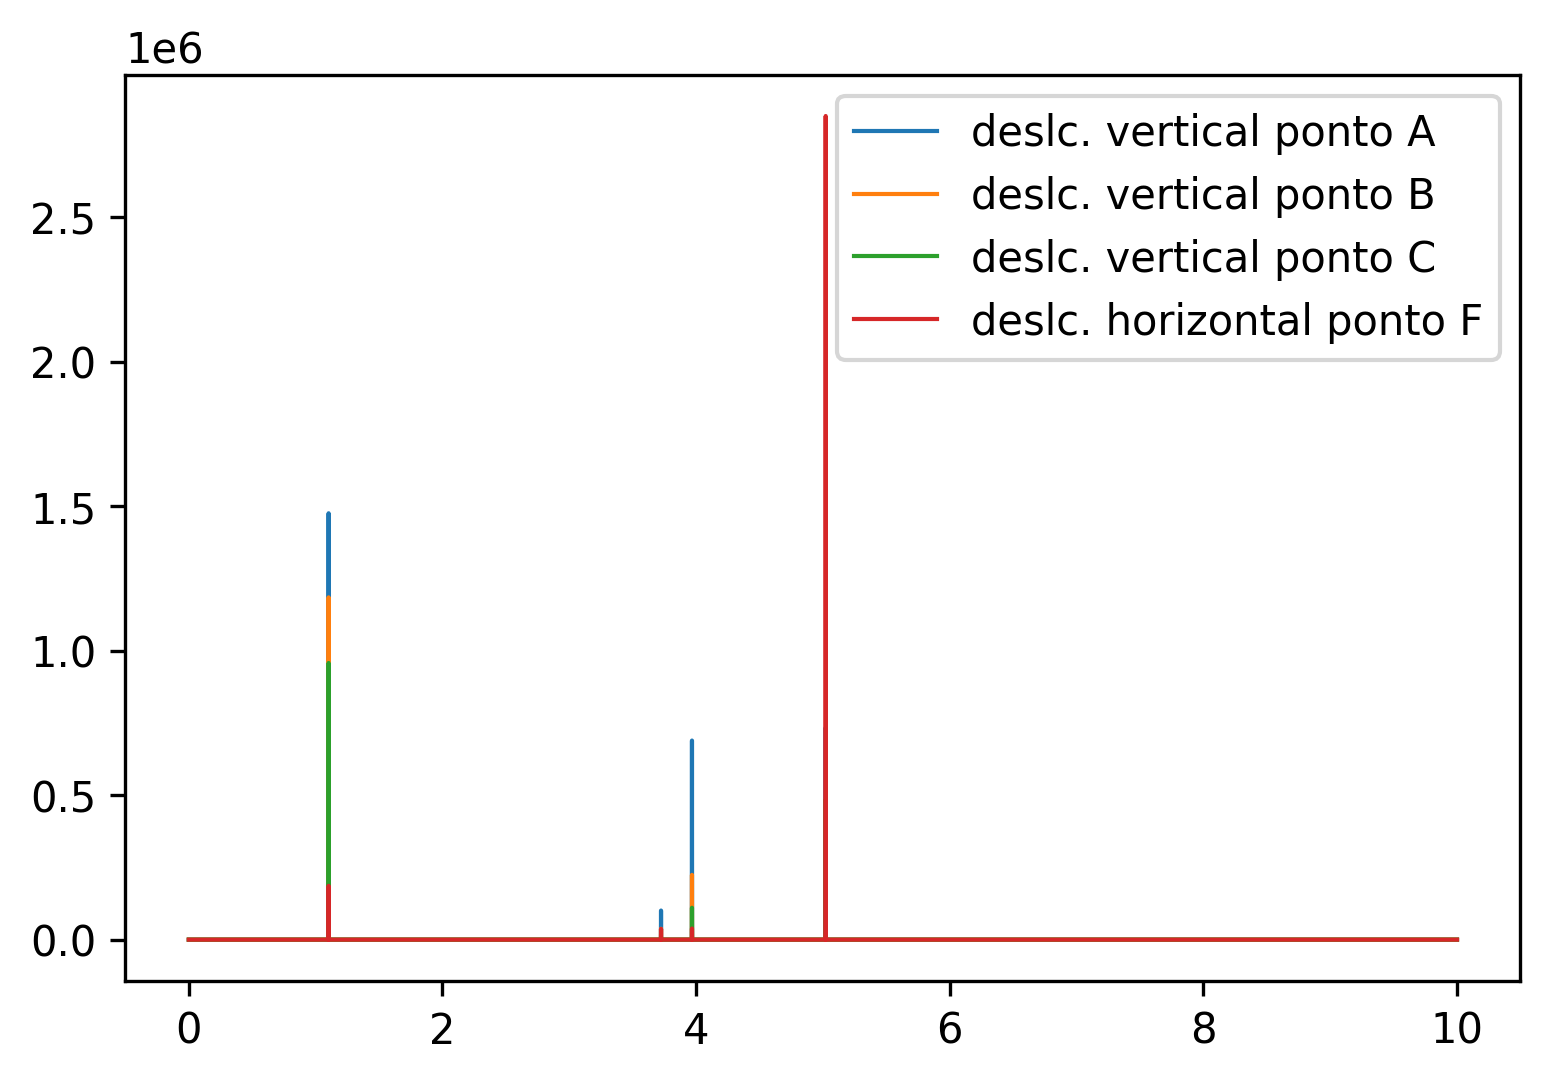

In [212]:
plt.figure(dpi=300)
plt.plot(omegas, U_harmonico[indice_A], label='deslc. vertical ponto A',   linewidth=1)
plt.plot(omegas, U_harmonico[indice_B], label='deslc. vertical ponto B',   linewidth=1)
plt.plot(omegas, U_harmonico[indice_C], label='deslc. vertical ponto C',   linewidth=1)
plt.plot(omegas, U_harmonico[indice_F], label='deslc. horizontal ponto F', linewidth=1)
plt.legend()

In [118]:
va = 0.5


In [119]:
U_transiente.shape

(267, 11000)

NameError: name 'time_vector' is not defined

<Figure size 1800x1200 with 0 Axes>

In [ ]:
indice_A = find_index_dispacement(sistema_hamonico, A, 'vertical')
indice_B = find_index_dispacement(sistema_hamonico, B, 'vertical')
indice_C = find_index_dispacement(sistema_hamonico, C, 'vertical')
indice_F = find_index_dispacement(sistema_hamonico, F, 'horizontal')

plt.figure(dpi=300)
plt.plot(time_vector, U_transiente[indice_A], label='deslc. vertical ponto A',   linewidth=1)
plt.plot(time_vector, U_transiente[indice_B], label='deslc. vertical ponto B',   linewidth=1)
plt.plot(time_vector, U_transiente[indice_C], label='deslc. vertical ponto C',   linewidth=1)
plt.plot(time_vector, U_transiente[indice_F], label='deslc. horizontal ponto F', linewidth=1)
plt.legend()

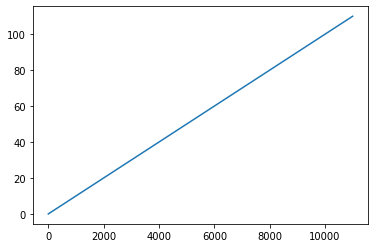

In [106]:
plt.plot(time_vector)

In [13]:
element = Elemento(
        np.array([1, 0]), 
        np.array([2, 0]), 
        'viga', 
        {
            'A': A2[0]*A2[1],
            'E': Young_modulus,
            'I': calculate_I(A2[0], A2[1]),
            'rho': rho,
        })
element.build_q_array(q(20, 9))
if element.Fe is not None:
    print(element.Fe)

[   0.      871.1111  145.1852    0.      871.1111 -145.1852]


In [19]:
p = sistema.point_list






#np.logical_and()
np.all(p > A,axis=0)
p[np.all(np.logical_and(p >= A, p<=B), axis=1)]

np.all(B >= A,)


True

True

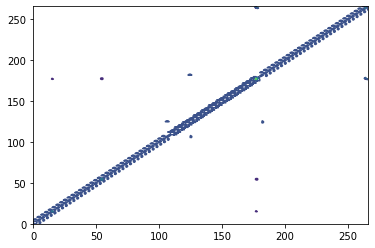

In [360]:

plt.contour(sistema.Keg)
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(sistema.Keg)

In [361]:
def globalize_K(Ke, total_size, idx):
    '''
    Função que transforma uma matriz Ke (local) em uma matriz K (global)
    
    Parameters
    ----------
    Ke: np.array (dim=len(idx)xlen(idx))
        Matriz de rigidez local
    total_size: int
        tamanho total do sistema (número de variáveis independentes)
    idx: list (or array-like)
        índice das variáveis que Ke se refere a
    '''
    Keg = np.zeros((total_size, total_size), dtype='complex')
    Keg[np.ix_(idx, idx)] = Ke
    
    return Keg



In [242]:
#checagem
aa, bb = sistema.point_list, sistema.elements
len(aa), len(bb)
llist = []
for b in bb:
    llist.append((np.rad2deg(b.theta), b.L, b.tipo))
llist

[(0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'viga/portico'),
 (0.0, 1.0, 'v

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]
 [16  0]
 [17  0]
 [18  0]
 [19  0]
 [20  0]
 [21  0]
 [22  0]
 [23  0]
 [24  0]
 [25  0]
 [26  0]
 [27  0]
 [28  0]
 [29  0]
 [30  0]
 [31  0]
 [32  0]
 [33  0]
 [34  0]
 [35  0]
 [36  0]
 [37  0]
 [38  0]
 [39  0]
 [40  0]
 [41  0]
 [42  0]
 [43  0]
 [44  0]
 [45  0]
 [46  0]
 [47  0]
 [48  0]
 [49  0]
 [50  0]
 [51  0]
 [52  0]
 [53  0]
 [54  0]
 [55  0]
 [56  0]
 [57  0]
 [58  0]
 [59  0]
 [60  0]
 [61  0]
 [62  0]
 [63  0]
 [64  0]
 [65  0]
 [36 -5]
 [36 -4]
 [36 -3]
 [36 -2]
 [36 -1]
 [36  0]
 [36  1]
 [36  2]
 [36  3]
 [36  4]
 [36  5]
 [36  6]
 [36  7]
 [36  8]
 [36  9]
 [36 10]
 [36 11]
 [36 12]
 [36 13]
 [36 14]
 [36 15]
 [36 16]
 [36 17]
 [36 18]
 [ 5  0]
 [36 18]
 [18  0]
 [36 18]
 [65  0]
 [36 18]]


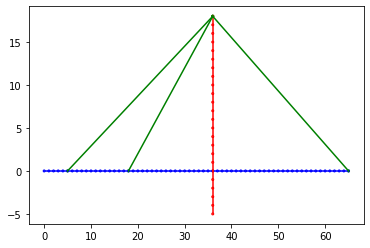

In [649]:
sistema_pontos = np.array(
    [
       plataforma_points 
    +  torre_points 
    +  cabo1_points 
    +  cabo2_points 
    +  cabo3_points
    ]
)

print(sistema_pontos[0])
#para o plot da estrutura
dict_estrutura = {
    'b' : [zip(*plataforma_points)],
    'r' : [zip(*torre_points)],
    'g' : [zip(*cabo1_points),zip(*cabo2_points), zip(*cabo3_points)],
}
plot_struct(dict_estrutura)

In [154]:
sistema_pontos


array([[ 0,  0],
       [ 3,  0],
       [ 5,  0],
       [ 8,  0],
       [ 9,  0],
       [12,  0],
       [15,  0],
       [18,  0],
       [21,  0],
       [24,  0],
       [27,  0],
       [30,  0],
       [33,  0],
       [36,  0],
       [39,  0],
       [42,  0],
       [45,  0],
       [48,  0],
       [51,  0],
       [54,  0],
       [57,  0],
       [60,  0],
       [63,  0],
       [65,  0],
       [36, -5],
       [36, -2],
       [36,  0],
       [36,  3],
       [36,  6],
       [36,  9],
       [36, 12],
       [36, 15],
       [36, 18],
       [ 5,  0],
       [36, 18],
       [18,  0],
       [36, 18],
       [65,  0],
       [36, 18]])

In [83]:
def calculate_I(b, h=None):
    '''
    Função que calcula o momento de inércia
    
    Parameters
    ----------
    b: float
        largura da seção transversal (ou diâmetro)
    h: float (default=None)
        altura da seção transversal, se None considera que trata-se
        de uma seção transversal circular
    '''
    if h is None:
        return np.pi*b**4/12
    return b*h**3/12

self.A  ,
self.I  ,) = params.values()

array([[36,  0]])

In [108]:
a = np.array(plataforma_points +  torre_points + cabo1_points + cabo2_points + cabo3_points)
np.unique(a, axis=0)

array([[ 0,  0],
       [ 3,  0],
       [ 5,  0],
       [ 8,  0],
       [ 9,  0],
       [12,  0],
       [15,  0],
       [18,  0],
       [21,  0],
       [24,  0],
       [27,  0],
       [30,  0],
       [33,  0],
       [36, -5],
       [36, -2],
       [36,  0],
       [36,  3],
       [36,  6],
       [36,  9],
       [36, 12],
       [36, 15],
       [36, 18],
       [39,  0],
       [42,  0],
       [45,  0],
       [48,  0],
       [51,  0],
       [54,  0],
       [57,  0],
       [60,  0],
       [63,  0],
       [65,  0]])

In [109]:
a

array([[ 0,  0],
       [ 3,  0],
       [ 5,  0],
       [ 8,  0],
       [ 9,  0],
       [12,  0],
       [15,  0],
       [18,  0],
       [21,  0],
       [24,  0],
       [27,  0],
       [30,  0],
       [33,  0],
       [36,  0],
       [39,  0],
       [42,  0],
       [45,  0],
       [48,  0],
       [51,  0],
       [54,  0],
       [57,  0],
       [60,  0],
       [63,  0],
       [65,  0],
       [36, -5],
       [36, -2],
       [36,  0],
       [36,  3],
       [36,  6],
       [36,  9],
       [36, 12],
       [36, 15],
       [36, 18],
       [ 5,  0],
       [36, 18],
       [18,  0],
       [36, 18],
       [65,  0],
       [36, 18]])

In [97]:
def reduz_matriz(A, idx, eliminate=False):
    '''
    Reduz a matriz global com condições de contorno para
    uma matriz apenas com as linhas e colunas dos elementos
    não triviais (não nulos) do sistema
    
    Parameters
    ----------
    A: np.ndarray
        matriz global
    idx: list
        lista dos índices (inteiros, 0-indexados)
    '''
    A_red     = A.copy()
    dimension = A.ndim
    if eliminate == True:
        all_indexes = np.arange(0, A.shape[0])
        difference = set(all_indexes) - set(idx)
        idx = list(difference)
    if dimension > 1:
        A_red = A[np.ix_(idx, idx)]
    else:
        A_red = A[np.ix_(idx)]
    return A_red
teste = np.array([1,2,3, 4,5,6,7,8,9])
teste = reduz_matriz(teste, [0], eliminate=True)
teste

array([2, 3, 4, 5, 6, 7, 8, 9])

In [88]:
a = set(np.arange(0, teste.shape[0])) - set([0])

In [94]:
list(a)

[1, 2]

In [93]:
np.array([1,2])

array([1, 2])

In [ ]:
modo = 5
legenda = r"Sexto modo de vibrar; $\omega = $" + f'{values[modo]:.4f}'

sistema.plot_struct(escala=8, deformacoes=vectors[modo], node_names=False, elements_names=False, fontsize=4, legend=legenda)
